In [2]:
import os
import torch
import matplotlib.pyplot as plt
from dptb.postprocess.unified.system import TBSystem

# Define paths (Adjust to your local environment)
root_dir = os.path.abspath("../ToW90_PythTB") 
model_path = os.path.join(root_dir, "models", "nnsk.ep20.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")


TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
Pybinding is not installed. Please install it via `pip install pybinding`


In [3]:
# Initialize the system
tbsys = TBSystem(data=struct_path, calculator=model_path)

print("TBSystem Initialized.")
# You can access the underlying ASE atoms object
print(f"Atoms: {tbsys.atoms}")

The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


TBSystem Initialized.
Atoms: Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.71499984016137, 2.71499984016137], [2.71499984016137, 0.0, 2.71499984016137], [2.71499984016137, 2.71499984016137, 0.0]])


In [4]:
tbsys.set_electrons({'Si':4})
tbsys.get_efermi(kmesh=[5,5,5])

/Users/aisiqg/Desktop/work/github/DeePTB/.venv/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  return torch._nested_tensor_from_tensor_list(ts, dtype, None, device, None)
eig_solver is not set, using default 'torch'.


-8.566754648927265

In [5]:
kpath_config = {
    "method": "abacus",
    "kpath": [
        [0.000, 0.000, 0.000, 50], # G
        [0.500, 0.000, 0.500, 50], # X
        [0.625, 0.250, 0.625, 1],  # U
        [0.375, 0.375, 0.750, 50], # K
        [0.000, 0.000, 0.000, 50], # G 
        [0.500, 0.500, 0.500, 50], # L
        [0.500, 0.250, 0.750, 50], # W
        [0.500, 0.000, 0.500, 1]   # X
    ],
    "klabels": ["G", "X", "X/U", "K", "G", "L", "W", "X"]
}

# Set the configuration
tbsys.band.set_kpath(**kpath_config)

eig_solver is not set, using default 'torch'.


Eigenvalues shape: (302, 18)


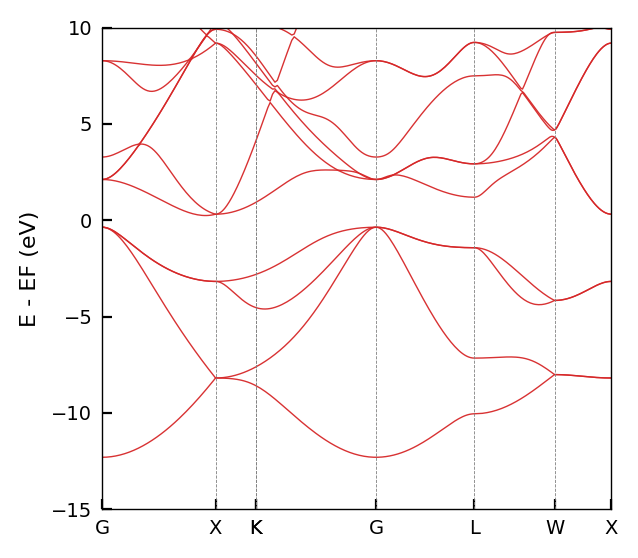

In [6]:
# Compute bands
# Compute bands with rough Fermi estimation
bs_data = tbsys.band.compute()

# Access raw data if needed
print(f"Eigenvalues shape: {bs_data.eigenvalues.shape}")

# Plot the result
tbsys.band.plot(emin=-15, emax=10, filename="silicon_bands.png")

In [7]:
tb_model = tbsys.export.to_pythtb()

----- k_path report begin ----------
real-space lattice vectors
 [[0.    2.715 2.715]
 [2.715 0.    2.715]
 [2.715 2.715 0.   ]]
k-space metric tensor
 [[ 0.10175 -0.03392 -0.03392]
 [-0.03392  0.10175 -0.03392]
 [-0.03392 -0.03392  0.10175]]
internal coordinates of nodes
 [[0.   0.   0.  ]
 [0.   0.5  0.5 ]
 [0.25 0.5  0.75]
 [0.   0.   0.  ]
 [0.5  0.5  0.5 ]]
reciprocal-space lattice vectors
 [[-0.18416  0.18416  0.18416]
 [ 0.18416 -0.18416  0.18416]
 [ 0.18416  0.18416 -0.18416]]
cartesian coordinates of nodes
 [[0.00000e+00 0.00000e+00 0.00000e+00]
 [1.84162e-01 0.00000e+00 0.00000e+00]
 [1.84162e-01 9.20810e-02 6.93889e-18]
 [0.00000e+00 0.00000e+00 0.00000e+00]
 [9.20810e-02 9.20810e-02 9.20810e-02]]
list of segments:
  length = 0.18416  from  [0. 0. 0.]  to  [0.  0.5 0.5]
  length = 0.09208  from  [0.  0.5 0.5]  to  [0.25 0.5  0.75]
  length =  0.2059  from  [0.25 0.5  0.75]  to  [0. 0. 0.]
  length = 0.15949  from  [0. 0. 0.]  to  [0.5 0.5 0.5]
node distance list: [0.      0.

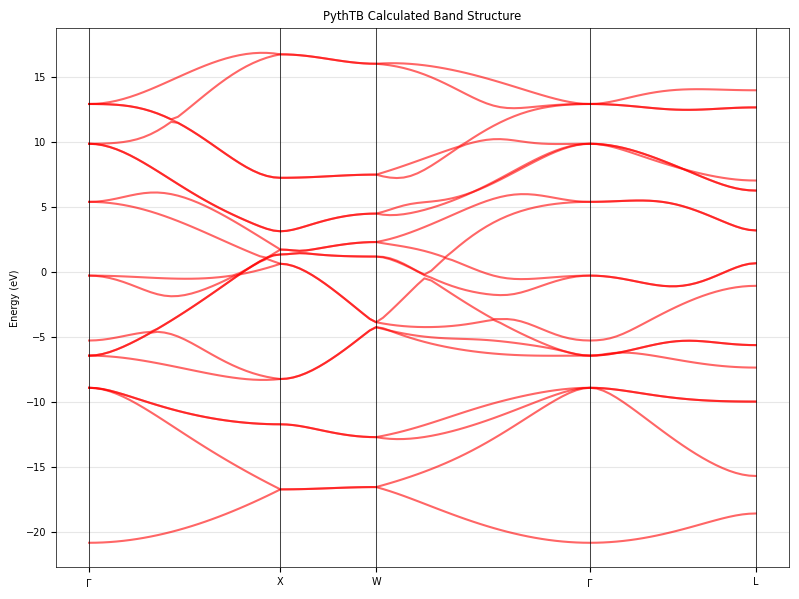

In [8]:

# Define K-path in PythTB format (Si High Symmetry Points)
# Gamma=(0,0,0), X=(0,0.5,0.5), L=(0.5,0.5,0.5), W=(0.25, 0.5, 0.75), K=(0.375, 0.375, 0.75)
# Note: DeePTB and PythTB might define paths slightly differently, but critical points match.

k_path_nodes = [
    [0.0, 0.0, 0.0], # Gamma
    [0.0, 0.5, 0.5], # X
    [0.25, 0.5, 0.75], # W
    [0.0, 0.0, 0.0], # Gamma
    [0.5, 0.5, 0.5], # L
]
k_path_labels = [r'$\Gamma$', 'X', 'W', r'$\Gamma$', 'L']

# Create k-path
(k_vec, k_dist, k_node) = tb_model.k_path(k_path_nodes, 100)

# Solve for eigenvalues
print("Solving with PythTB...")
evals = tb_model.solve_all(k_vec)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
# PythTB returns shape (num_orbitals, num_kpoints)
for i in range(evals.shape[0]):
    ax.plot(k_dist, evals[i,:], 'r-', lw=1.5, alpha=0.6, label='PythTB' if i==0 else "")

# Decorate
for n in k_node:
    ax.axvline(n, color='k', lw=0.5)
ax.set_xticks(k_node)
ax.set_xticklabels(k_path_labels)
ax.set_ylabel("Energy (eV)")
ax.set_title("PythTB Calculated Band Structure")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
evals = tb_model.solve_all(tbsys.band.klist)

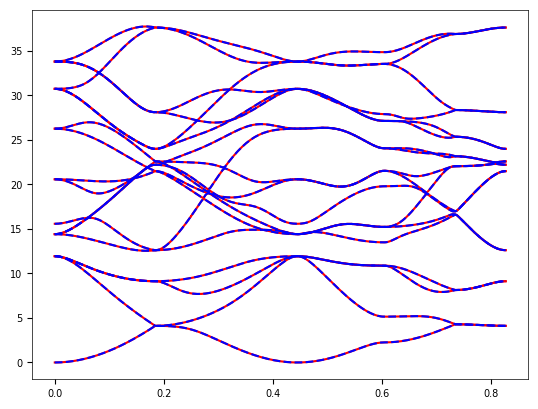

In [13]:
refeig = evals[:,:].T
plt.plot(tbsys.band_data.xlist,refeig - refeig.min() ,'r')
plt.plot(tbsys.band_data.xlist,tbsys.band_data.eigenvalues - tbsys.band_data.eigenvalues.min(),'b--')
plt.show()

In [14]:
tbsys.export.to_wannier90()

In [15]:
from pythtb import w90


In [22]:
w90_obj = w90('./', 'wannier90') 
tb_model_wan = w90_obj.model()
print("Loaded W90 model into PythTB.")

# Solve PythTB
evals_pythtb_wan = tb_model_wan.solve_all(tbsys.band.klist)

Loaded W90 model into PythTB.


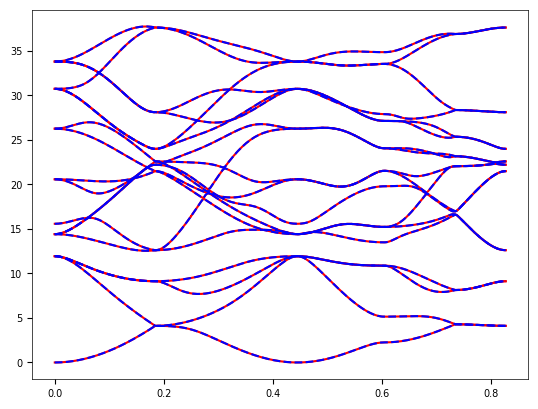

In [23]:
refeig = evals_pythtb_wan[:,:].T
plt.plot(tbsys.band_data.xlist,refeig - refeig.min() ,'r')
plt.plot(tbsys.band_data.xlist,tbsys.band_data.eigenvalues - tbsys.band_data.eigenvalues.min(),'b--')
plt.show()